In this tutorial guide, we use tensorflow to predict digits.

Tensorflow uses the concepts of graphs and sessions for its computation. If using Keras, these details are abstracted but here it is important to know them.

TF uses a dataflow graph where each node represent a computation wheras edges show the data production or consumption.

When we create session in tensorflow that is when we run through the graph.

First lets import the usual libraries.

We read the handwritten digits data from the mnist dataset and 

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


The data has training, test and validation sets. Below we see the amount of images in each one of them

In [3]:
print("Size of:")
print("Training set: {}".format(len(data.train.labels)))
print("Test set: {}".format(len(data.test.labels)))
print("Validation set: {}".format(len(data.validation.labels)))

Size of:
Training set: 55000
Test set: 10000
Validation set: 5000


While loading the data itself, for class labels we mentioned a flag one_hot to True, which meant that for each image the label is a vector of 10. In each vector one of the value is 1 and the rest 0, which represents the class of the digit.
For test set we need the the class also, so we find it the reverse way, i.e. from one hot we find the class

In [0]:
data.test.cls = np.argmax(data.test.labels, axis=1)
num_classes = 10

In [5]:
data.train.images.shape

(55000, 784)

With the above cell, we see that each image has a shape of 784. These are 784 pixel values which can also be represented as 28x28. And as these are grayscale, there is only one channel.

In [0]:
img_size = 28
img_shape = (img_size, img_size)
num_channels = 1

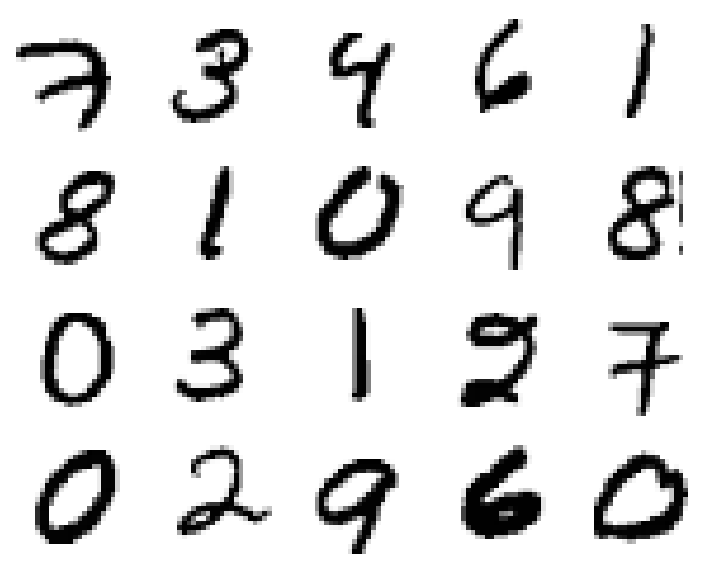

In [7]:
def overview(start, end, images):
    fig = plt.figure(figsize=(10,10))
    for i in range(start, end):
        input_img = images[i]
        ax = fig.add_subplot(5,5,i+1)
        ax.imshow(input_img.reshape(img_shape))
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0, 20, data.train.images)

Now we go to create the computational graph.

A heavy use of placeholders is done to effectively use the graph. We give it a name, shape and a type. This way any data can flow through it. This unit is called a tensor in the graph.

As each input will be a 784 size vector, before sending it to the network we shall convert each image from a 784 vector to a 28x28x1

In [0]:
x = tf.placeholder(tf.float32, shape=[None, img_size * img_size], name='x')
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')

X_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Also, we find the class each input image belongs to from the Y_label which is 10 dimensional class vector in this case.

In [0]:
Y_label_cls = tf.argmax(y, axis=1)

Below we define our network

In [0]:
conv1 = tf.layers.conv2d(inputs=X_image, filters=32, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], padding='SAME', strides=2)
drop1 = tf.layers.dropout(inputs=pool1, rate=0.25)

In [0]:
conv2 = tf.layers.conv2d(inputs=drop1, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], padding='SAME', strides=2)
drop2 = tf.layers.dropout(inputs=pool2, rate=0.25)

In [0]:
conv3 = tf.layers.conv2d(inputs=drop2, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], padding='SAME', strides=2)
drop3 = tf.layers.dropout(inputs=pool3, rate=0.25)

In [0]:
conv4 = tf.layers.conv2d(inputs=drop3, filters=256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], padding='SAME', strides=2)
drop4 = tf.layers.dropout(inputs=pool4, rate=0.25)

In [0]:
flat = tf.layers.flatten(drop4)

In [0]:
dense1 = tf.layers.dense(inputs=flat, units=128, activation=tf.nn.relu)
drop5 = tf.layers.dropout(inputs=dense1, rate=0.25)

In [0]:
dense2 = tf.layers.dense(inputs=drop5, units=128, activation=tf.nn.relu)
drop5 = tf.layers.dropout(inputs=dense2, rate=0.25)

In [0]:
logits = tf.layers.dense(inputs=drop5, units=10)

In [0]:
Y_pred = tf.nn.softmax(logits=logits)


In [19]:
Y_pred_cls = tf.argmax(Y_pred, dimension=1)


Instructions for updating:
Use the `axis` argument instead


In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)

In [0]:
loss = tf.reduce_mean(cross_entropy)

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [0]:
correct_prediction = tf.equal(Y_pred_cls, Y_label_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We define some parameters like batch size and epochs to run for

In [0]:
batch_size = 32
num_epochs = 25

Now that we have our graph created, a tensorflow session is needed to run the graph.

This session will run through our graph with the batch size. It replaces the placeholders with the images and labels coming from the batch load.
After each epoch, we back-propagate to minimize the loss.

Finally, when the optimization is over we will see the accuracy over the test dataset.

Variables have to be initialized before hand in the session before the optimization begines

In [25]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(num_epochs):
        avg_cost = 0.
        total_batch = int(data.train.num_examples/batch_size)

        for i in range(total_batch):
            batch_x, batch_y = data.train.next_batch(batch_size)
            feed_dict_train = {x: batch_x, y: batch_y}
            _, c = sess.run([optimizer, loss], feed_dict=feed_dict_train)
            avg_cost += c / total_batch

        print("Epoch:", '%02d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    
    correct_prediction = tf.equal(Y_pred_cls, Y_label_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: data.test.images, y: data.test.labels}))

('Epoch:', '01', 'cost=', '0.341568323')
('Epoch:', '02', 'cost=', '0.087993558')
('Epoch:', '03', 'cost=', '0.061728755')
('Epoch:', '04', 'cost=', '0.047212652')
('Epoch:', '05', 'cost=', '0.038040448')
('Epoch:', '06', 'cost=', '0.031928239')
('Epoch:', '07', 'cost=', '0.026652907')
('Epoch:', '08', 'cost=', '0.021570049')
('Epoch:', '09', 'cost=', '0.019742979')
('Epoch:', '10', 'cost=', '0.015144466')
('Epoch:', '11', 'cost=', '0.014903251')
('Epoch:', '12', 'cost=', '0.011654471')
('Epoch:', '13', 'cost=', '0.010213887')
('Epoch:', '14', 'cost=', '0.008475549')
('Epoch:', '15', 'cost=', '0.008420058')
('Epoch:', '16', 'cost=', '0.007857541')
('Epoch:', '17', 'cost=', '0.005809290')
('Epoch:', '18', 'cost=', '0.006477191')
('Epoch:', '19', 'cost=', '0.005408866')
('Epoch:', '20', 'cost=', '0.005603186')
('Epoch:', '21', 'cost=', '0.003926132')
('Epoch:', '22', 'cost=', '0.004557434')
('Epoch:', '23', 'cost=', '0.004532664')
('Epoch:', '24', 'cost=', '0.003335097')
('Epoch:', '25',